In [1]:
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt

import sys

sys.path.append("../../src")
from Load_data.prepare_data import *

2026-02-07 14:33:51.932838: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def build_binary_any_tf_dataset(
    train_image_dir,
    test_image_dir,
    train_xml,
    test_xml,
    img_size=(64, 64),
    batch_size=32,
    shuffle_buffer=1000
):
    print("🛠️ Building BINARY_ANY TF dataset")

    # -------- TRAIN --------
    train_paths, fn_train = load_image_paths(train_image_dir)
    raw_train = parse_cvat_xml_all_labels(train_xml)
    labels_train = label_Y_binary(raw_train)
    Y_train = build_label_array(fn_train, labels_train)

    # -------- TEST --------
    test_paths, fn_test = load_image_paths(test_image_dir)
    raw_test = parse_cvat_xml_all_labels(test_xml)
    labels_test = label_Y_binary(raw_test)
    Y_test = build_label_array(fn_test, labels_test)

    def _load_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        img = tf.cast(img, tf.float32) / 255.0
        return img, label

    Y_train = Y_train.reshape(-1)
    Y_test  = Y_test.reshape(-1)

    # -------- TF DATASETS --------
    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, Y_train))
    train_ds = (
        train_ds
        .shuffle(shuffle_buffer)
        .map(_load_image, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    test_ds = tf.data.Dataset.from_tensor_slices((test_paths, Y_test))
    test_ds = (
        test_ds
        .map(_load_image, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    print("✅ TF datasets ready")
    return train_ds, test_ds


In [3]:
train_ds, test_ds = build_binary_any_tf_dataset(
    train_image_dir="../../EIDSeg_Dataset/data/train/images/default",
    test_image_dir ="../../EIDSeg_Dataset/data/test/images/default",
    train_xml="../../EIDSeg_Dataset/data/train/train.xml",
    test_xml ="../../EIDSeg_Dataset/data/test/test.xml",
    img_size=(160, 160),
    batch_size=32
)



🛠️ Building BINARY_ANY TF dataset
✅ TF datasets ready


2026-02-07 14:33:53.801397: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-07 14:33:53.865888: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-07 14:33:53.867155: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

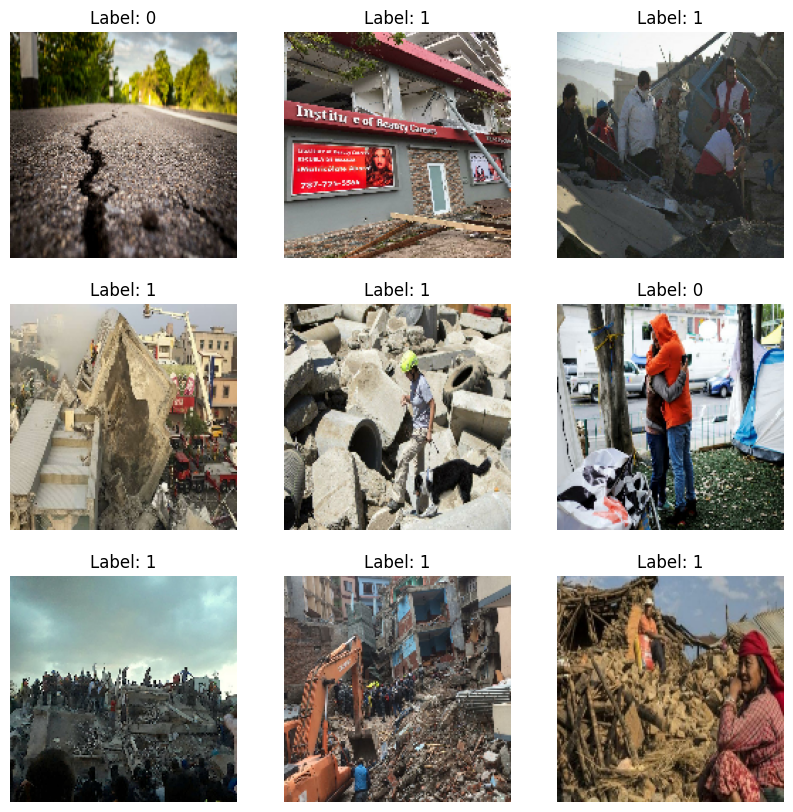

In [5]:

for images, labels in train_ds.take(1):
    images_np = images.numpy()

    # Detect pixel range
    pmin, pmax = images_np.min(), images_np.max()

    # If normalized to [-1,1] -> convert back to [0,255]
    if pmin < 0:
        images_np = (images_np + 1) * 127.5

    # If in [0,1] -> scale to [0,255]
    elif pmax <= 1.5:
        images_np = images_np * 255

    images_np = images_np.astype("uint8")

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images_np[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")

    plt.show()
    break


In [ ]:

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

def my_model(image_shape=(160, 160)):
    # Full input shape
    input_shape = image_shape + (3,)

    # Data augmentation module
    aug = data_augmenter()

    # Base model (feature extractor)
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet"
    )

    # Freeze the backbone
    base_model.trainable = False

    # Input layer
    inputs = tf.keras.Input(shape=input_shape)

    # Apply augmentation
    x = aug(inputs)

    # Preprocessing expected by MobileNetV2
    x = preprocess_input(x)

    # Extract features
    x = base_model(x, training=False)

    # Pool + dropout + classification head
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.2)(x)

    # Binary classification: 1 output neuron + sigmoid
    outputs = tfl.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)

    return model